In [3]:
%%capture
!pip install plotly
!pip install nltk
!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Visualisierungen
- Mean Sentiment over time per party
- Sentiment per MP
-  Männliche vs. weibliche Politiker vergleich
- Minority vergleich (überhaupt möglich?)
- Hate unter Politikern
- Wordclouds

In [2]:
df = pd.read_csv("../full_datasets/politicians_mentions_predicted.csv")
#df = df.drop(['Unnamed: 0'], axis=1)
df.head()
df = df.drop_duplicates()
len(df)

/tmp/ipykernel_4363/2912122355.py:1: DtypeWarning:

Columns (0,1,2,6) have mixed types. Specify dtype option on import or set low_memory=False.



620587

In [3]:
df.head(5)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,quote_count,retweets,replies,likes,Partei,model_predictions
0,0,0,0,8.098958e+08,GtzFrmming,19656.0,17975,"MdB, Parlamentarischer Geschäftsführer, Mitgli...","Berlin, Deutschland",„Dekolonialisierung“: Berlin benennt Lüderitzs...,2022-12-04 23:23:16+00:00,3.0,21.0,42.0,51.0,AfD,0.0
1,1,1,1,8.109576e+17,PetrBystronAfD,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern","@BeiRainer Aha. Und wer entschied, was eine ""F...",2022-12-04 19:32:15+00:00,0.0,1.0,1.0,3.0,AfD,0.0
2,2,2,2,7.293602e+17,Marcus_Buehl,2798.0,992,"Mitglied der AfD-Bundestagsfraktion, Mitglied ...","Thüringen, Deutschland",Heute waren Steffen Janich &amp; ich wieder be...,2022-12-04 19:11:40+00:00,0.0,2.0,0.0,7.0,AfD,0.0
3,3,3,3,7.133614e+17,StBrandner,38579.0,31499,"Industriekaufmann, Rechtsanwalt, MdB🇩🇪 - direk...","Mal hier, mal da...",@Karl_Lauterbach Wer jemanden anzeigt...😉\nhtt...,2022-12-04 18:54:10+00:00,1.0,5.0,5.0,81.0,AfD,0.0
4,4,4,4,9.177563e+17,JuergenBraunAfD,6386.0,11393,@AfDimBundestag-Abgeordneter | Sprecher für #M...,"Waiblingen, Deutschland",Nur 2 Spieler wollten dümmliche Polit-Mätzchen...,2022-12-04 17:29:08+00:00,1.0,17.0,5.0,71.0,AfD,1.0


In [4]:
new = []
for index, row in df.iterrows():
    try:
        tolists = ast.literal_eval(row["mentioned"])
        new.append(tolists)
    except:
        #row["mentioned"] = []
        new.append("NA")

In [5]:
df["mentioned_list"] = new

In [103]:
df.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,quote_count,retweets,replies,likes,mentioned,Runs,Partei,model_predictions,mentioned_list
0,0,0,1,1435940649572966400.0,CHARLYCAPRI4,1,14.0,NaN,NaN,"@SWagenknecht Sie sind gescheitert ,weil Sie d...",2022-03-31 23:51:42+00:00,0,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,[SWagenknecht]
1,1,1,2,528677411.0,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,@SWagenknecht Mittlerweile langweilen Sie .\nK...,2022-03-31 23:51:27+00:00,0,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,[SWagenknecht]


In [104]:
exploded_df = df.explode("mentioned_list")

In [105]:
exploded_df = exploded_df.reset_index()
exploded_df.head(2)

,level_0,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,...,created_at,quote_count,retweets,replies,likes,mentioned,Runs,Partei,model_predictions,mentioned_list
0,0,0,0,1,1435940649572966400.0,CHARLYCAPRI4,1,14.0,NaN,NaN,...,2022-03-31 23:51:42+00:00,0,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,SWagenknecht
1,1,1,1,2,528677411.0,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,...,2022-03-31 23:51:27+00:00,0,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,SWagenknecht


In [106]:
exploded_df['mentioned_list'] = exploded_df['mentioned_list'].map(lambda x: x.lower() if isinstance(x,str) else x)

In [107]:
exploded_df.mentioned_list.head(2)

0    swagenknecht
1    swagenknecht
Name: mentioned_list, dtype: object

## Merge exploded dataframe with extracted twitter usernames to get right party

In [108]:
twitter = pd.read_csv("twitter_usernames_extracted.csv",sep=";")
twitter.head(2)

,Unnamed: 0.1,Unnamed: 0,full_name,party,twitter,username
0,0,0,Sanae Abdi,SPD,https://twitter.com/abdisanae'],abdisanae
1,1,1,Valentin Abel,FDP,['https://twitter.com/Valentin_C_Abel'],Valentin_C_Abel


In [109]:
twitter['username'] = twitter['username'].map(lambda x: x.lower() if isinstance(x,str) else x)

In [110]:
twitter['username'].head(2)

0          abdisanae
1    valentin_c_abel
Name: username, dtype: object

In [111]:
test = exploded_df.merge(twitter, left_on='mentioned_list', right_on='username',suffixes=['', '_'])

In [112]:
test = test.drop(["Unnamed: 0.1_", "Unnamed: 0_", "twitter", "level_0", "username_"],axis=1)
test

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,retweets,replies,likes,mentioned,Runs,Partei,model_predictions,mentioned_list,full_name,party
0,0,0,1,1435940649572966400.0,CHARLYCAPRI4,1,14.0,NaN,NaN,"@SWagenknecht Sie sind gescheitert ,weil Sie d...",...,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke
1,1,1,2,528677411.0,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,@SWagenknecht Mittlerweile langweilen Sie .\nK...,...,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke
2,2,2,3,762265140.0,nimmdenbus,1574,118892.0,Take the bus! Prenez le bus! Mein Herz schlägt...,NaN,@MarvinWendland1 @SWagenknecht @BinBerlinerIn ...,...,0,0.0,0.0,"['MarvinWendland1', 'SWagenknecht', 'BinBerlin...",Linke_polis_1,Die Linke,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke
3,5,5,6,1357858541160259584.0,MeisterKlar,0,487.0,Nichts! ich bin einmalig wie jeder andere auch!,NaN,@SWagenknecht Lassen sie sich nicht in die Eck...,...,0,0.0,0.0,['SWagenknecht'],Linke_polis_1,Die Linke,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke
4,6,6,9,762265140.0,nimmdenbus,1574,118892.0,Take the bus! Prenez le bus! Mein Herz schlägt...,NaN,"@SWagenknecht @BinBerlinerIn Sahra, ich habe d...",...,0,0.0,1.0,"['SWagenknecht', 'BinBerlinerIn']",Linke_polis_1,Die Linke,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766147,1486984,186984,2860922,784800210744647680.0,ali_spirkl,225,3950.0,"Cosmopolit, Deutschland? Naja, überbewertet",NaN,@AfDimBundestag @edgar_naujok Ein so ein grind...,...,0,0.0,0.0,"['AfDimBundestag', 'edgar_naujok']",AfD_polis_1,AfD,1,edgar_naujok,Edgar Naujok,AfD
2766148,1487391,187391,2861504,1437459734433521664.0,UlMar80106448,276,3223.0,Krankenpfleger - natürlich geimpft mit dem dr...,"Freital, Deutschland",@AfDimBundestag @edgar_naujok E\n@edgar_naujok...,...,0,0.0,0.0,"['AfDimBundestag', 'edgar_naujok', 'edgar_nauj...",AfD_polis_1,AfD,0,edgar_naujok,Edgar Naujok,AfD
2766149,1487391,187391,2861504,1437459734433521664.0,UlMar80106448,276,3223.0,Krankenpfleger - natürlich geimpft mit dem dr...,"Freital, Deutschland",@AfDimBundestag @edgar_naujok E\n@edgar_naujok...,...,0,0.0,0.0,"['AfDimBundestag', 'edgar_naujok', 'edgar_nauj...",AfD_polis_1,AfD,0,edgar_naujok,Edgar Naujok,AfD
2766150,1487400,187400,2861521,910913583168573440.0,AfDimBundestag,80292,11425.0,AfD-Fraktion im Deutschen Bundestag https://t....,"Berlin, Deutschland","""Aus Deutschland eingereiste IS-Kämpfer haben ...",...,5,4.0,37.0,['edgar_naujok'],AfD_polis_1,AfD,0,edgar_naujok,Edgar Naujok,AfD


In [127]:
len(test)

2766152

In [113]:
test.to_csv("mentions_predicted_exploded.csv")

## Merge exploded df with MdB dataset to get sex of MP

In [116]:
%%capture
!pip install openpyxl

In [117]:
mdb = pd.read_excel("MdB_20WP_Kontaktdaten.xlsx")
mdb.head()

,Name BT,Vorname BT,Titel,Adel,Praefix,BT_Zusatz,Geschlecht,NAME BT Zusammensetzung 1,NAME BT Zusammensetzung 2,Fraktion,...,BL,Anrede,Anschrift,Anschrift Straße,Anschrift PLZ,Anschrift Ort,INTERN,E-Mail,Vorwahl,Vermittlung
0,Abdi,Sanae,NaN,NaN,NaN,NaN,Frau,Sanae Abdi,"Abdi, Sanae",SPD,...,NW,Sehr geehrte Frau Abgeordnete,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,sanae.abdi@bundestag.de,+49 30 227,0
1,Abel,Valentin,NaN,NaN,NaN,NaN,Herrn,Valentin Abel,"Abel, Valentin",FDP,...,BW,Sehr geehrter Herr Abgeordneter,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,valentin.abel@bundestag.de,+49 30 227,0
2,Abraham,Knut,NaN,NaN,NaN,NaN,Herrn,Knut Abraham,"Abraham, Knut",CDU/CSU,...,BB,Sehr geehrter Herr Abgeordneter,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,knut.abraham@bundestag.de,+49 30 227,0
3,Adler,Katja,NaN,NaN,NaN,NaN,Frau,Katja Adler,"Adler, Katja",FDP,...,HE,Sehr geehrte Frau Abgeordnete,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,katja.adler@bundestag.de,+49 30 227,0
4,Aeffner,Stephanie,NaN,NaN,NaN,NaN,Frau,Stephanie Aeffner,"Aeffner, Stephanie",BÜ90/GR,...,BW,Sehr geehrte Frau Abgeordnete,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,stephanie.aeffner@bundestag.de,+49 30 227,0


In [124]:
sex = test.merge(mdb, left_on='full_name', right_on='NAME BT Zusammensetzung 1',suffixes=['', '_'])
sex.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,BL,Anrede,Anschrift,Anschrift Straße,Anschrift PLZ,Anschrift Ort,INTERN,E-Mail,Vorwahl,Vermittlung
0,0,0,1,1435940649572966400.0,CHARLYCAPRI4,1,14.0,NaN,NaN,"@SWagenknecht Sie sind gescheitert ,weil Sie d...",...,NW,Sehr geehrte Frau Abgeordnete,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,sahra.wagenknecht@bundestag.de,+49 30 227,0
1,1,1,2,528677411.0,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,@SWagenknecht Mittlerweile langweilen Sie .\nK...,...,NW,Sehr geehrte Frau Abgeordnete,Deutscher Bundestag,Platz der Republik 1,11011,Berlin,im Hause,sahra.wagenknecht@bundestag.de,+49 30 227,0


In [125]:
sex = sex.drop(["Anrede", "Anschrift", "Anschrift Straße", "Anschrift PLZ", "Anschrift Ort", "INTERN", "E-Mail", "Vorwahl", "Vermittlung"],axis=1)
sex = sex.drop(["Praefix", "BT_Zusatz", "NAME BT Zusammensetzung 1", "NAME BT Zusammensetzung 2", "Fraktion", "Wahlkreis-Nr.", "Wahlkreisname/Bundesland", "BL", "Partei", "Name BT", "Vorname BT", "Titel", "Adel"],axis=1)
sex.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,replies,likes,mentioned,Runs,model_predictions,mentioned_list,full_name,party,Geschlecht,Gewählt in Vorperiode
0,0,0,1,1435940649572966400.0,CHARLYCAPRI4,1,14.0,NaN,NaN,"@SWagenknecht Sie sind gescheitert ,weil Sie d...",...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
1,1,1,2,528677411.0,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,@SWagenknecht Mittlerweile langweilen Sie .\nK...,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja


In [126]:
len(sex)

2752124

In [128]:
sex.to_csv("mentions_predicted_exploded.csv")

# Data Analysis

In [3]:
# because on mention row was found in the created_at column
df = df[~df['created_at'].astype(str).str.startswith('[')]
df = df[~df['created_at'].astype(str).str.startswith('S')]
df = df[~df['created_at'].astype(str).str.startswith('F')]
df = df[~df['created_at'].astype(str).str.startswith('C')]
df = df[~df['created_at'].astype(str).str.startswith('A')]
df = df[~df['created_at'].astype(str).str.startswith('D')]
df = df[~df['created_at'].astype(str).str.startswith('B')]

In [4]:
df["created_at"][0]

'2022-12-04 23:23:16+00:00'

In [4]:
df["created_at"] = df["created_at"].astype('datetime64[ns]') 
df["created_at"] = df.created_at.dt.to_pydatetime()

In [9]:
len(df)

620587

In [5]:
# Date Spalte erstellen
df["Date"]  = df["created_at"]
#df['Date']= pd.to_datetime(df['Date'])

df["HOF"] = df["model_predictions"]
df.loc[(df.model_predictions == 1),'Label']='HOF'
df.loc[(df.model_predictions == 0),'Label']='NOT'

In [11]:
df.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,quote_count,retweets,replies,likes,Partei,model_predictions,mentioned_list,Date,HOF,Label
0,0,0,0,8.098958e+08,GtzFrmming,19656.0,17975,"MdB, Parlamentarischer Geschäftsführer, Mitgli...","Berlin, Deutschland",„Dekolonialisierung“: Berlin benennt Lüderitzs...,...,3.0,21.0,42.0,51.0,AfD,0.0,NA,2022-12-04 23:23:16,0.0,NOT
1,1,1,1,8.109576e+17,PetrBystronAfD,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern","@BeiRainer Aha. Und wer entschied, was eine ""F...",...,0.0,1.0,1.0,3.0,AfD,0.0,NA,2022-12-04 19:32:15,0.0,NOT


In [16]:
#mask = (df['Date'] < '2021-12-31')
#df = df.loc[mask]
#df.head()

In [12]:
df.Partei.value_counts()

Bündnis 90/Die Grünen    130097
FDP                      117681
SPD                       81941
CSU/CDU                   72776
AfD                       49062
Die Linke                 44537
fraktionslos               6838
Name: Partei, dtype: int64

In [10]:
afd = df[df["Partei"] == "AfD"]
cducsu = df[df["Partei"] == "CSU/CDU"]
linke = df[df["Partei"] == "Die Linke"]
fdp = df[df["Partei"] == "FDP"]
gruene = df[df["Partei"] == "Bündnis 90/Die Grünen"]
spd = df[df["Partei"] == "SPD"]

In [11]:
# group by party and look at sentiment distribution per party
afd_pos = afd[afd["model_predictions"] == 0].username.count()
afd_neg = afd[afd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
spd_pos = spd[spd["model_predictions"] == 0].username.count()
spd_neg = spd[spd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
linke_pos = linke[linke["model_predictions"] == 0].username.count()
linke_neg = linke[linke["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
fdp_pos = fdp[fdp["model_predictions"] == 0].username.count()
fdp_neg = fdp[fdp["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
gruene_pos = gruene[gruene["model_predictions"] == 0].username.count()
gruene_neg = gruene[gruene["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
cducsu_pos = cducsu[cducsu["model_predictions"] == 0].username.count()
cducsu_neg = cducsu[cducsu["model_predictions"] == 1].username.count()

pos = df[df["model_predictions"] == 0].username.count()
neg = df[df["model_predictions"] == 1].username.count()

## Plots over Time

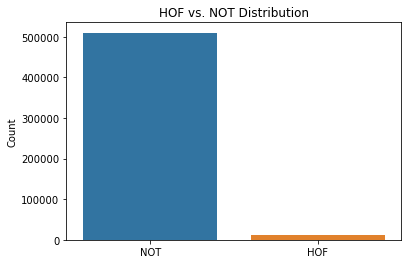

In [12]:
ax = sns.barplot(x=["NOT", "HOF"], y=[pos,neg])
ax.set_title('HOF vs. NOT Distribution')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

In [15]:
ax.figure.savefig("./plots/politicians_plots/politicians_hof_distribution.png")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



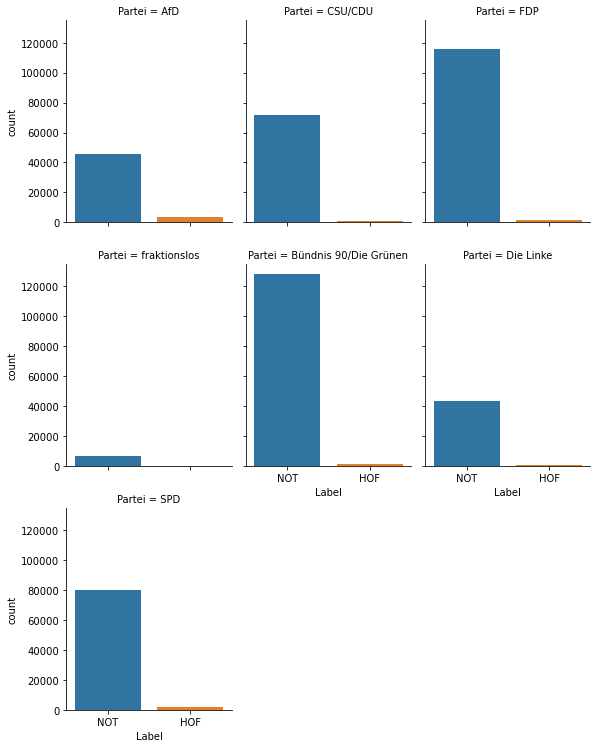

In [16]:
# Plot
g = sns.catplot("Label", col="Partei", col_wrap=3,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab10')

#fig.suptitle('sf')
plt.show()
g.savefig('./plots/politicians_plots/politicians_party_hof_distribution.png')

In [40]:
day = []

for index, row in df.iterrows():
    date = row["Date"].date()
    day.append(date)
       
df["day"] = day
df.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,retweets,replies,likes,Partei,model_predictions,Date,HOF,Label,month,day
0,0,0,0,8.098958e+08,GtzFrmming,19656.0,17975,"MdB, Parlamentarischer Geschäftsführer, Mitgli...","Berlin, Deutschland",„Dekolonialisierung“: Berlin benennt Lüderitzs...,...,21.0,42.0,51.0,AfD,0.0,2022-12-04 23:23:16,0.0,NOT,2022-12,2022-12-04
1,1,1,1,8.109576e+17,PetrBystronAfD,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern","@BeiRainer Aha. Und wer entschied, was eine ""F...",...,1.0,1.0,3.0,AfD,0.0,2022-12-04 19:32:15,0.0,NOT,2022-12,2022-12-04


In [6]:
df['month'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y-%m')

In [12]:
df.head()

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,retweets,replies,likes,Partei,model_predictions,Date,HOF,Label,month,day
0,0,0,0,8.098958e+08,GtzFrmming,19656.0,17975,"MdB, Parlamentarischer Geschäftsführer, Mitgli...","Berlin, Deutschland",„Dekolonialisierung“: Berlin benennt Lüderitzs...,...,21.0,42.0,51.0,AfD,0.0,2022-12-04 23:23:16,0.0,NOT,2022-12,2022-12-04
1,1,1,1,8.109576e+17,PetrBystronAfD,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern","@BeiRainer Aha. Und wer entschied, was eine ""F...",...,1.0,1.0,3.0,AfD,0.0,2022-12-04 19:32:15,0.0,NOT,2022-12,2022-12-04
2,2,2,2,7.293602e+17,Marcus_Buehl,2798.0,992,"Mitglied der AfD-Bundestagsfraktion, Mitglied ...","Thüringen, Deutschland",Heute waren Steffen Janich &amp; ich wieder be...,...,2.0,0.0,7.0,AfD,0.0,2022-12-04 19:11:40,0.0,NOT,2022-12,2022-12-04
3,3,3,3,7.133614e+17,StBrandner,38579.0,31499,"Industriekaufmann, Rechtsanwalt, MdB🇩🇪 - direk...","Mal hier, mal da...",@Karl_Lauterbach Wer jemanden anzeigt...😉\nhtt...,...,5.0,5.0,81.0,AfD,0.0,2022-12-04 18:54:10,0.0,NOT,2022-12,2022-12-04
4,4,4,4,9.177563e+17,JuergenBraunAfD,6386.0,11393,@AfDimBundestag-Abgeordneter | Sprecher für #M...,"Waiblingen, Deutschland",Nur 2 Spieler wollten dümmliche Polit-Mätzchen...,...,17.0,5.0,71.0,AfD,1.0,2022-12-04 17:29:08,1.0,HOF,2022-12,2022-12-04


In [48]:
#df['day'] = (i.date() for i in df["Date"])
day_sentiment_df = df.pivot_table(index=['Partei', 'month'], values='model_predictions', aggfunc='mean').reset_index()
day_sentiment_df

,Partei,month,model_predictions
0,AfD,2020-01,0.098008
1,AfD,2020-02,0.098266
2,AfD,2020-03,0.061878
3,AfD,2020-04,0.047753
4,AfD,2020-05,0.060606
...,...,...,...
247,fraktionslos,2022-08,0.044898
248,fraktionslos,2022-09,0.013029
249,fraktionslos,2022-10,0.012048
250,fraktionslos,2022-11,0.032609


In [73]:
def setup_font(plt):
    # font_manager.fontManager.addfont(FONT_PATH)
    # prop = font_manager.FontProperties(fname=FONT_PATH)

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams.update({"font.size": 14})
    # plt.rcParams['font.sans-serif'] = prop.get_name()
    return plt

PARTY_COLORS = {
    "SPD": "#E3000F",
    "CSU/CDU": "#000000",
    "Bündnis 90/Die Grünen": "#1AA037",
    "Die Linke": "#800080",
    "FDP": "#FFEF00",
    "AfD": "#0489DB",
}

REG_COLORS = {
    "Government": "#E3000F",
    "Opposition": "#0489DB",
}

PARTY_ORDER = ["SPD", "CSU/CDU", "Bündnis 90/Die Grünen", "FDP", "AfD", "Die Linke"]
REG_ORDER = ["Government", "Opposition"]
POSITIVE_COLOR = "#76B041"  # "#006600"
NEGATIVE_COLOR = "#E4572E"  # "#FF0000"
NEUTRAL_COLOR = "#2E282A"  # "#999999"

FONT_PATH = "fonts/manrope-regular.otf"  #'fonts/LinLibertine_R.ttf'

# Global Plot Settings
sns.set(rc={"figure.dpi": 300})
sns.set(rc={"figure.figsize": (6, 3)})

def ploti_poli_line_graph_for_each_day(df, filename):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.dates as mdates

    sns.set_style("whitegrid")

    # Setup Font
    plt = setup_font(plt)

    _, ax = plt.subplots(figsize=(15, 6))

    # Set figure size and font size
    # plt.figure(figsize=(15, 6))
    plt.rcParams.update({"font.size": 16})

    # Plot the sentiment value for each party and month
    for party in PARTY_ORDER:
        ax.plot(
            df.loc[df["Partei"] == party, "month"],
            df.loc[df["Partei"] == party, "model_predictions"],
            label=party,
            color=PARTY_COLORS[party],
        )
    #df['day'] = pd.to_datetime(df['day'])
    #print(type(df.month[0]))
    # Set x-axis tick labels
   # plt.xticks()
    # set monthly locator
    df['month'] = pd.to_datetime(df['month'])
    print(type(df.month[0]))
    ax.xaxis.set_major_locator(mdates.MonthLocator()) #interval = 1
    plt.xticks(rotation=90)
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #plt.xticks(df['day'], rotation=90)

    # Add legend, axis labels and title
    legend = ax.legend(loc="upper left", title="Party", ncol=2)
    legend._legend_box.align = "left"
    plt.xlabel("Months of 2021", fontsize=18, labelpad=15)
    plt.ylabel("Mean HOF", x=-2, fontsize=18, labelpad=15)

    plt.grid(alpha=0.5)

    # Add labels for the positive and negative y-axis directions
    plt.text(
        -0.07,
        0.85,
        "HOF →",
        transform=ax.transAxes,
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=14,
        color=POSITIVE_COLOR,
    )
    plt.text(
        -0.07,
        0.15,
        "← NOT",
        transform=ax.transAxes,
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=14,
        color=NEGATIVE_COLOR,
    )

    # Set y-axis limit
    plt.ylim(0, 0.15)

    # Save as svg, png and pdf
    for f_type in [".png"]:
        plt.savefig(filename + f_type, dpi=300, bbox_inches="tight")

    plt.show()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


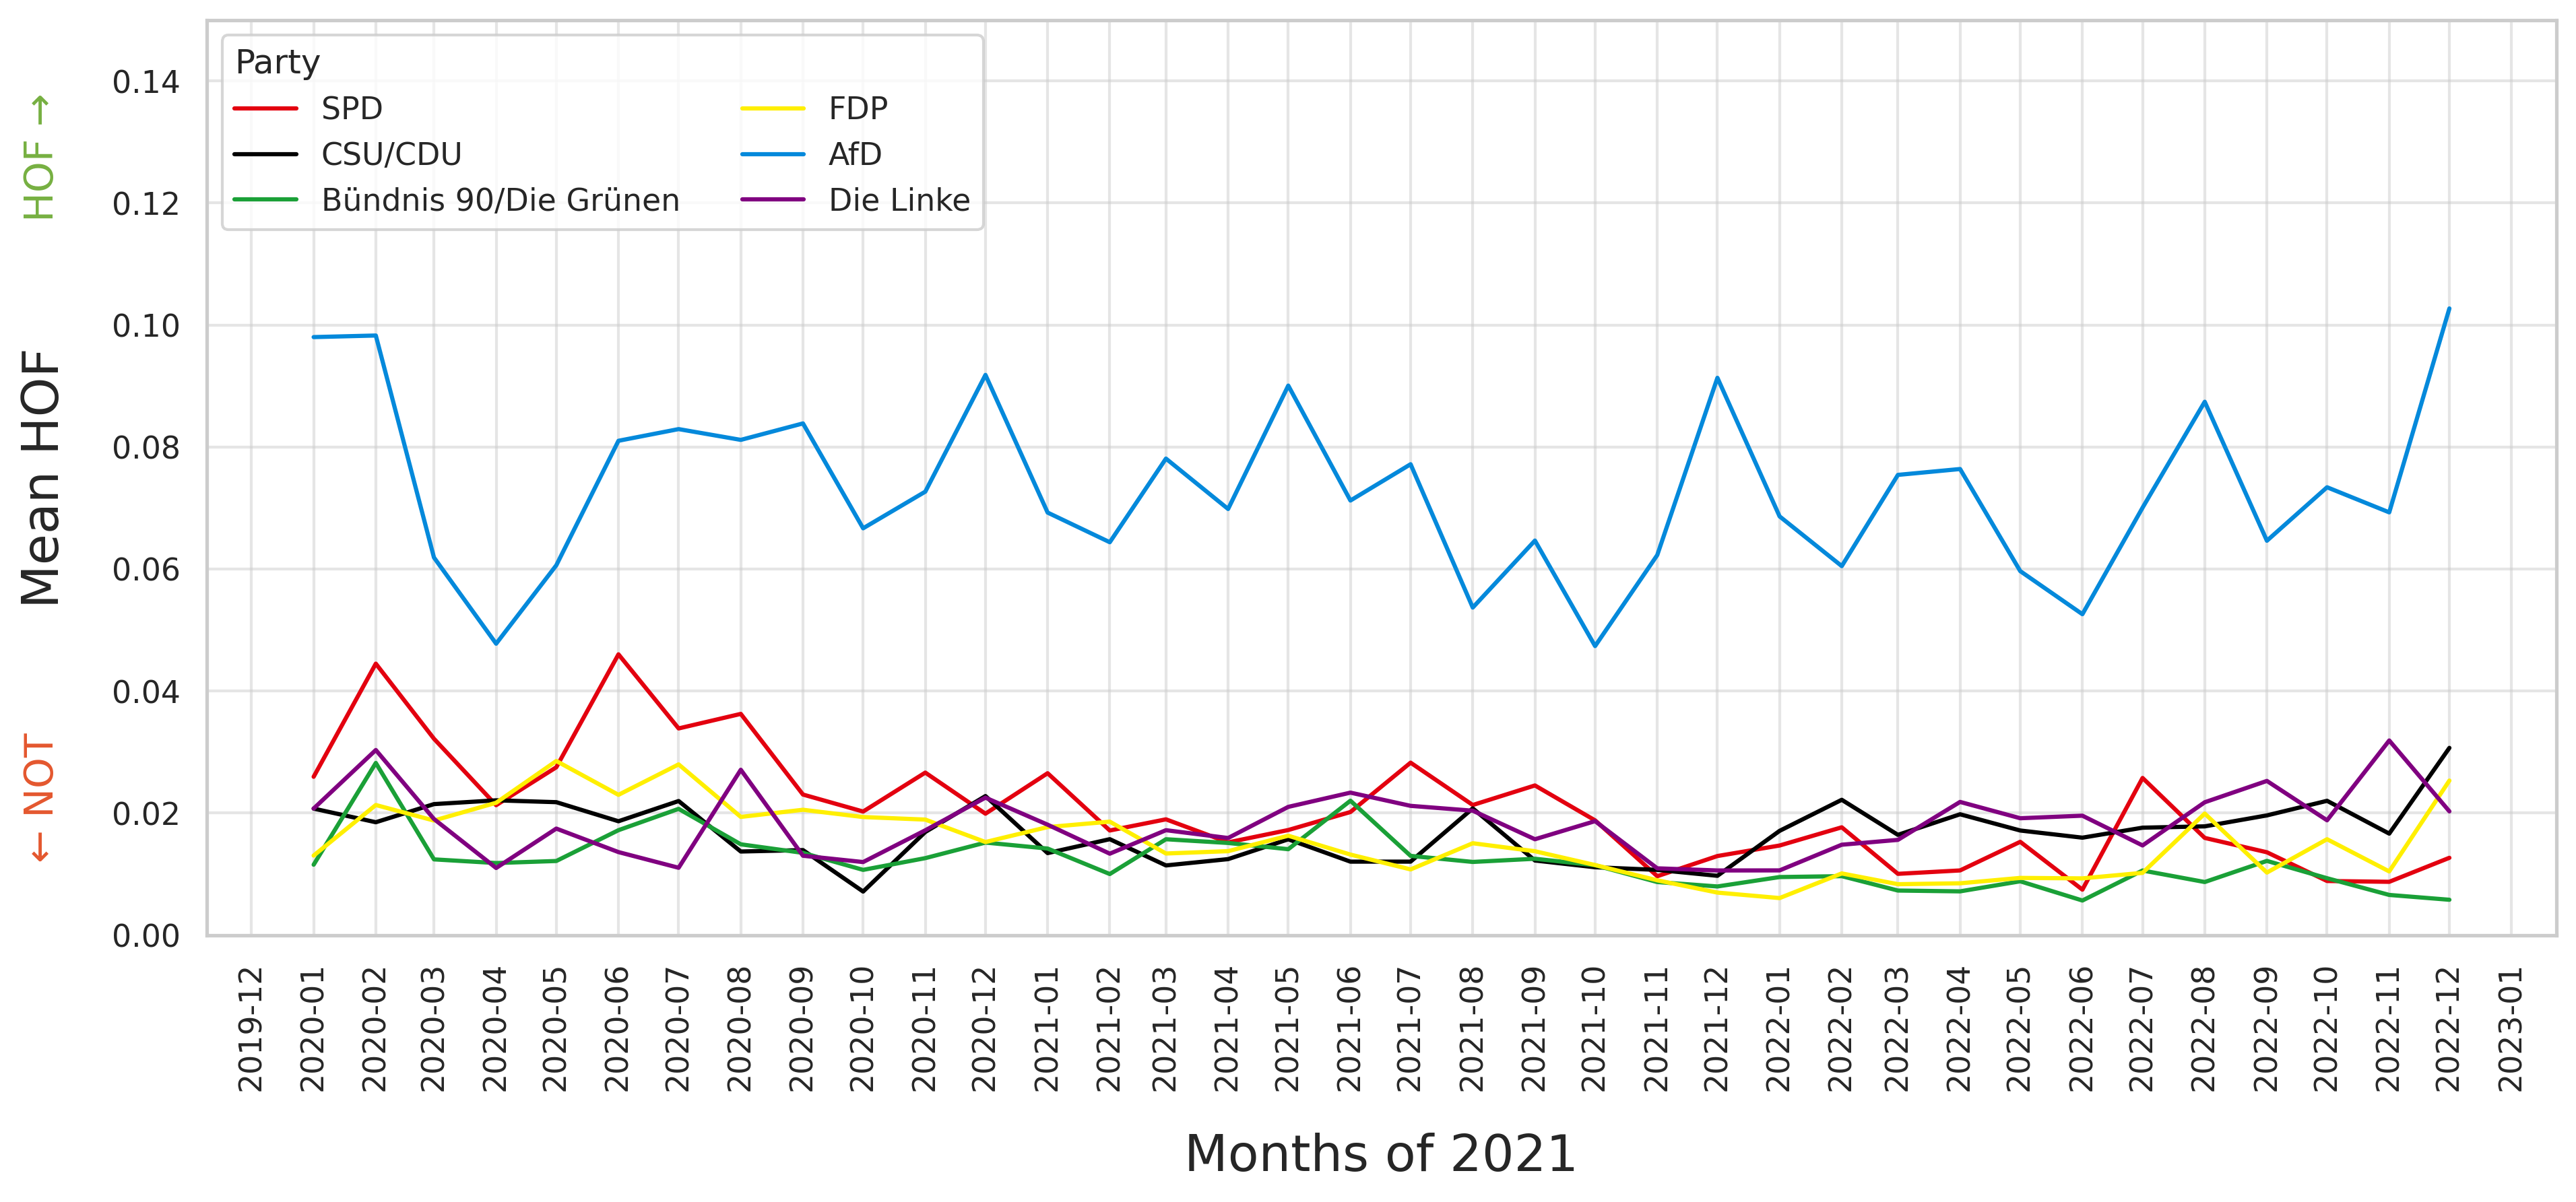

In [74]:
#from time_plots import plot_line_graph_for_each_day, plot_reg_line_graph_for_each_day, plot_percentage, plot_poli_line_graph_for_each_day
#change this graph
ploti_poli_line_graph_for_each_day(day_sentiment_df, "./plots/politicians_plots/politician_hof_party_over_time")

In [162]:
def f_2017(row):
    if row['Partei'] == "AfD":
        val = "Opposition"
    elif row['Partei'] == "Die Linke":
        val = "Opposition"
    elif row['Partei'] == "FDP":
        val = "Opposition"
    elif row['Partei'] == "Bündnis 90/Die Grünen":
        val = "Opposition"
    elif row['Partei'] == "CSU/CDU":
        val = "Government"
    elif row['Partei'] == "SPD":
        val = "Government"
    else:
        val = "NA"
    return val
        
def f_2021(row):
    if row['Partei'] == "AfD":
        val = "Opposition"
    elif row['Partei'] == "Die Linke":
        val = "Opposition"
    elif row['Partei'] == "CSU/CDU":
        val = "Opposition"
    elif row['Partei'] == "Bündnis 90/Die Grünen":
        val = "Government"
    elif row['Partei'] == "FDP":
        val = "Government"
    elif row['Partei'] == "SPD":
        val = "Government"
    else:
        val = "NA"
    return val

In [163]:
df['Regierungsstatus_2017'] = df.apply(f_2017, axis=1)
df['Regierungsstatus_2021'] = df.apply(f_2021, axis=1)

In [165]:
#df['day'] = (i.date for in in df["Date"])
reg_day_sentiment_df = df.pivot_table(index=['Regierungsstatus_2021', 'day'], values='model_predictions', aggfunc='mean').reset_index()
reg_day_sentiment_df

,Regierungsstatus_2021,day,model_predictions
0,Government,2022-02-01,0.179326
1,Government,2022-02-02,0.183889
2,Government,2022-02-03,0.200795
3,Government,2022-02-04,0.222192
4,Government,2022-02-05,0.206544
...,...,...,...
113,Opposition,2022-03-27,0.195213
114,Opposition,2022-03-28,0.190510
115,Opposition,2022-03-29,0.199134
116,Opposition,2022-03-30,0.191645


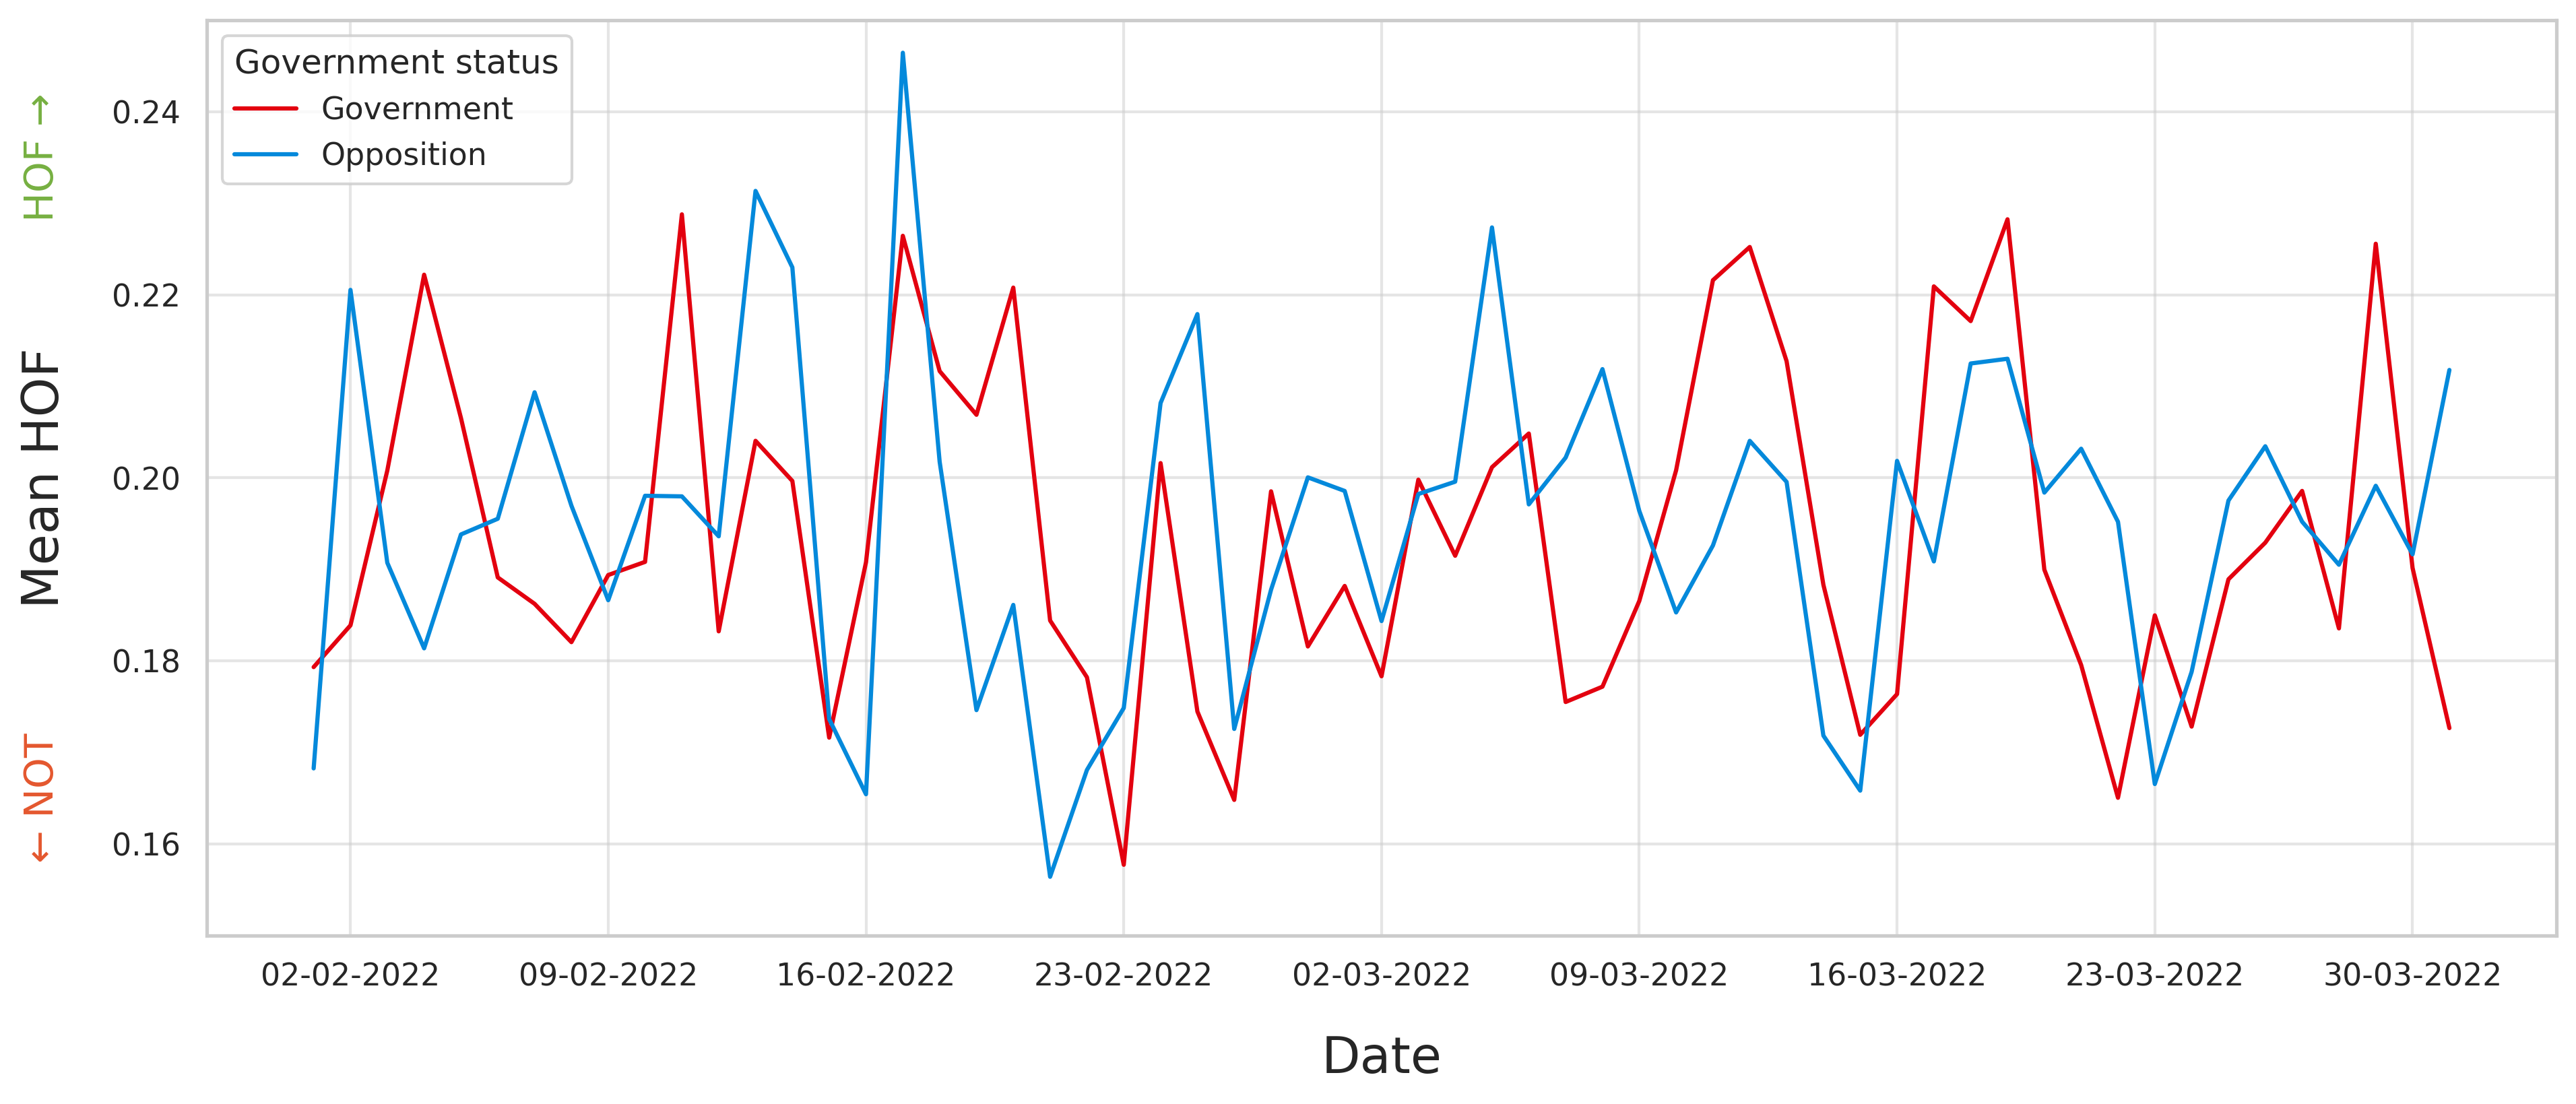

In [201]:
plot_reg_line_graph_for_each_day(reg_day_sentiment_df, "./plots/hof_regierung_over_time")

## Plot Percentage Distribution

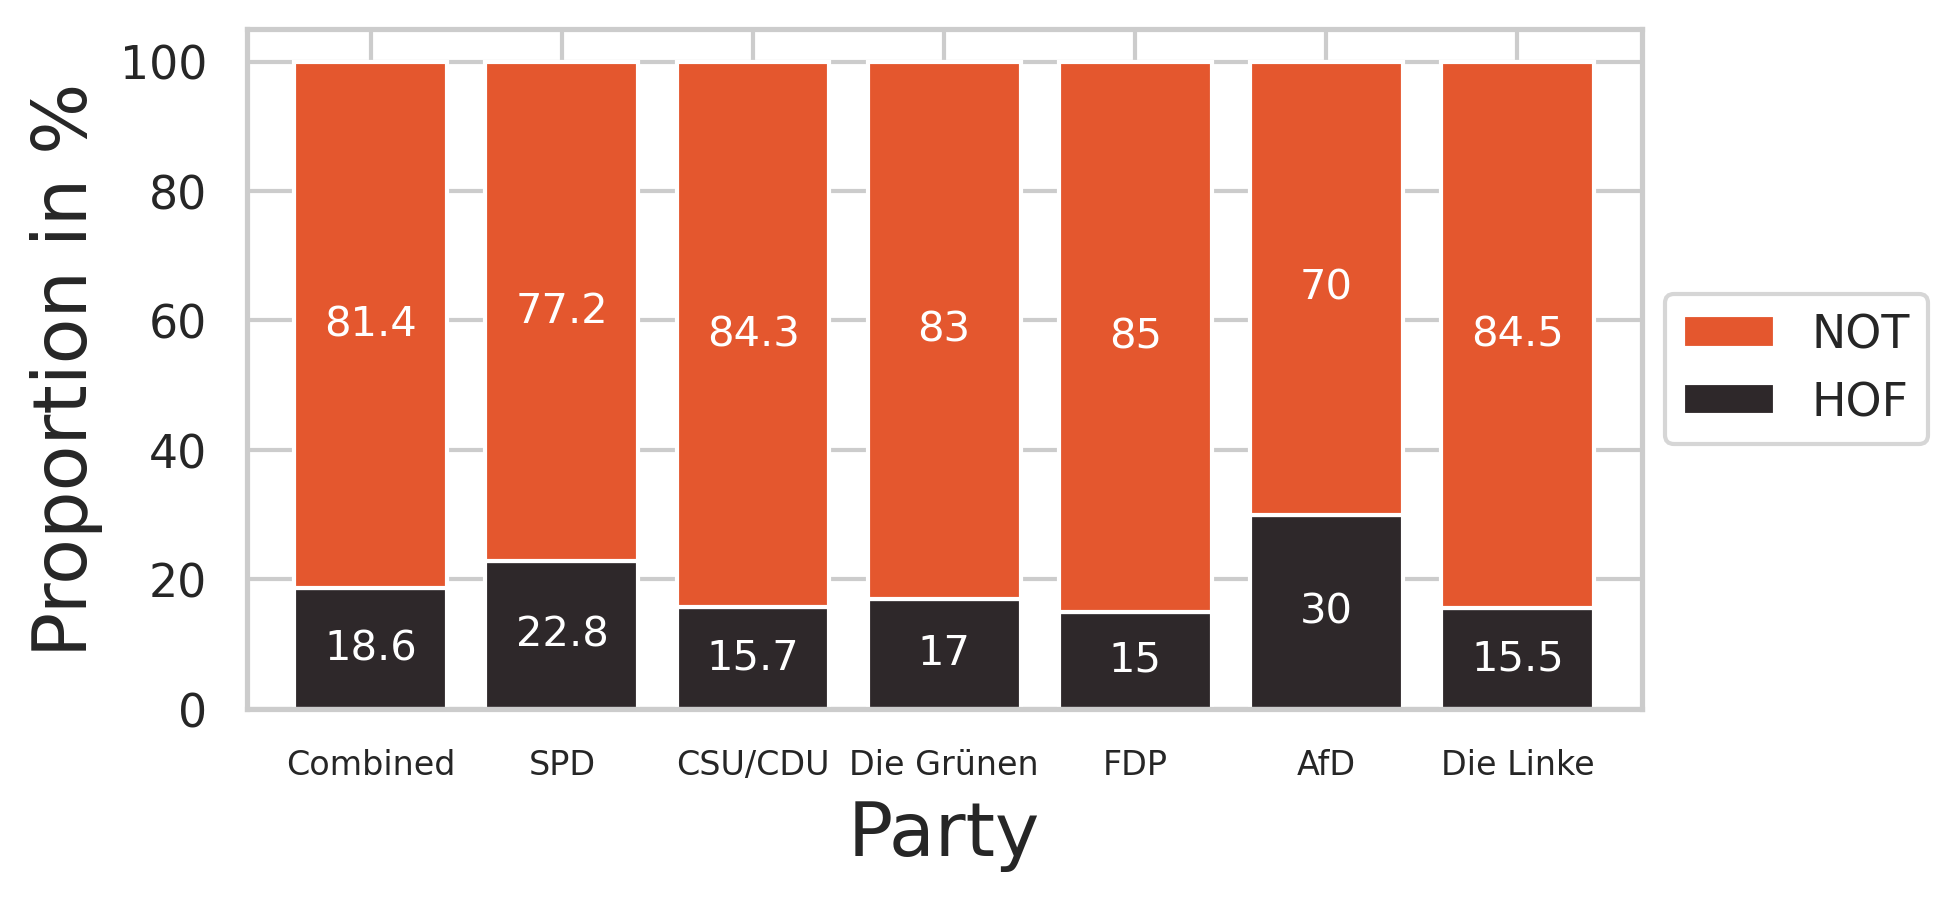

In [229]:
plot_percentage(df, "plots/percentage_distribution")

## Plot Gender

In [204]:
df = pd.read_csv("mentions_predicted_exploded.csv")
df.head(2)

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,...,replies,likes,mentioned,Runs,model_predictions,mentioned_list,full_name,party,Geschlecht,Gewählt in Vorperiode
0,0,0,0,1,1.435941e+18,CHARLYCAPRI4,1,14.0,NaN,NaN,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
1,1,1,1,2,5.286774e+08,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja


In [205]:
df["HOF"] = df["model_predictions"]
df.loc[(df.model_predictions == 1),'Label']='HOF'
df.loc[(df.model_predictions == 0),'Label']='NOT'

In [210]:
df.Geschlecht.value_counts()

Herrn    1907243
Frau      844881
Name: Geschlecht, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



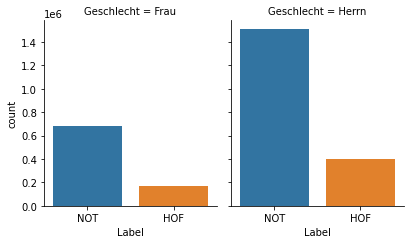

In [208]:
# Plot
g = sns.catplot("Label", col="Geschlecht", col_wrap=3,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab10')

#fig.suptitle('sf')
plt.show()
g.savefig('./plots/gender_hof_distribution.png')

## Hate per MP

In [213]:
hof = df[df["Label"] == "HOF"]
no = df[df["Label"] == "NOT"]

In [216]:
hof.full_name.value_counts()[:20]

Prof. Dr. Karl Lauterbach            142169
Dr. Janosch Dahmen                    35855
Olaf Scholz                           25181
Dr. Marco Buschmann                   24004
Stephan Brandner                      18035
Dr. Sahra Wagenknecht                 14881
Christian Lindner                     14806
Friedrich Merz                        13978
Dr. Marie-Agnes Strack-Zimmermann     13403
Beatrix von Storch                    12754
Emilia Fester                         12440
Dr. Ralf Stegner                      12399
Dr. Till Steffen                      12043
Dirk Wiese                            11811
Katrin Helling-Plahr                  11413
Dagmar Schmidt (Wetzlar)              11374
Dr. Norbert Röttgen                   11237
Ricarda Lang                          10850
Tessa Ganserer                        10230
Katrin Göring-Eckardt                  8230
Name: full_name, dtype: int64

In [217]:
no.full_name.value_counts()[:20]

Prof. Dr. Karl Lauterbach            402462
Dr. Marco Buschmann                  117462
Dr. Janosch Dahmen                   111810
Olaf Scholz                          108452
Christian Lindner                     78269
Friedrich Merz                        71610
Dr. Sahra Wagenknecht                 62242
Dr. Norbert Röttgen                   56524
Ricarda Lang                          55462
Dr. Marie-Agnes Strack-Zimmermann     40523
Katrin Göring-Eckardt                 36946
Dr. Till Steffen                      32114
Emilia Fester                         32009
Dirk Wiese                            30844
Dr. Ralf Stegner                      29777
Stephan Brandner                      29737
Katrin Helling-Plahr                  29050
Tessa Ganserer                        28836
Dagmar Schmidt (Wetzlar)              28532
Beatrix von Storch                    28386
Name: full_name, dtype: int64

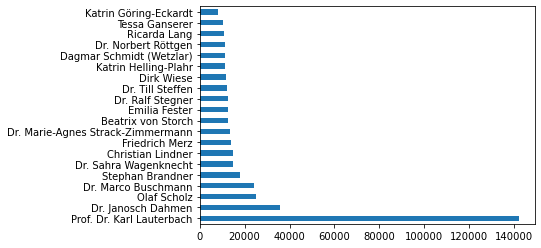

In [223]:
ax = hof['full_name'].value_counts()[:20].plot(kind='barh')
ax.figure.savefig("./plots/hof_on_mps.png")